<a href="https://colab.research.google.com/github/ayush111111/unet-fet/blob/main/training_VUnet_fetal_head_reducelr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Imports and augmentation


In [15]:
%cd drive/MyDrive/'Semester Project '/dataset_filled/
%ls


[Errno 2] No such file or directory: 'drive/MyDrive/Semester Project /dataset_filled/'
/content/drive/MyDrive/Semester Project /dataset_filled
 best_model_224_res_64epoch_1e-4_val_coef_98.h5
 best_model_224_res_reduce_lr2302.h5
 best_model_224_res_reduce_lr.h5
 best_model_224_res_retraining_1e-4.h5
 best_model_224_res_unk.h5
 best_model_224_res_VUNET.h5
 best_model_224_VUNET_reducelr_2802.h5
'Copy of best_model_224_res_64epoch_1e-4_val_coef_98.h5'
'Copy of best_model_224_res.h5'
 model.png
 test_set/
 training_set/


In [16]:

import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

In [17]:
import cv2
from skimage.transform import resize
from sklearn.model_selection import train_test_split

import tensorflow.keras
import tensorflow as tf
from tensorflow.keras import backend as K

K.set_image_data_format('channels_last')
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Add
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


IMG_HEIGHT = 224
IMG_WIDTH = 224

In [18]:


trainPath = "training_set/"
testPath = "test_set/"
trainList = sorted(os.listdir(trainPath))
testList = sorted(os.listdir(testPath))


train_image = []
train_mask = []
for i, item in enumerate(trainList):
    if i % 2 == 0:
        train_image.append(item)
    else:
        train_mask.append(item)
print("Ultrasound training images in dataset {}".format(len(train_image)))
print("Ultrasound training masks in dataset  {}".format(len(train_mask)))  

Ultrasound training images in dataset 999
Ultrasound training masks in dataset  999


800


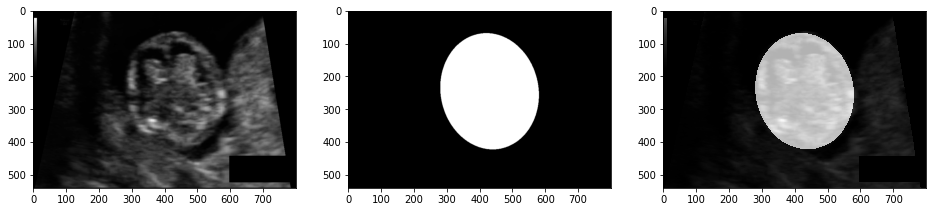

In [19]:

img = np.array(Image.open(trainPath+"006_HC.png"))
img_mask = np.array(Image.open(trainPath+"006_HC_Annotation.png"))
img_mask = np.ma.masked_where(img_mask == 0, img_mask)
print(len(img[0]))
#display images with mask
fig, ax = plt.subplots(1,3,figsize = (16,12))
ax[0].imshow(img, cmap = 'gray')
ax[1].imshow(img_mask, cmap = 'gray')
ax[2].imshow(img, cmap = 'gray', interpolation = 'none')
ax[2].imshow(img_mask, cmap = 'gray', interpolation = 'none', alpha = 0.7)


In [20]:

#
X = []
y = []
for image, mask in zip(train_image, train_mask):
    X.append(np.array(Image.open(trainPath+image)))
    y.append(np.array(Image.open(trainPath+mask)))

X = np.array(X)
y = np.array(y)

print("X_shape : ", X.shape)
print("y_shape : ", y.shape)



X_shape :  (999,)
y_shape :  (999,)


<ipython-input-20-5829c98f866b>:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.array(X)
<ipython-input-20-5829c98f866b>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y = np.array(y)


In [21]:

print("X_shape : ", X[0].shape)
print("y_shape : ", y[0].shape)



X_shape :  (540, 800)
y_shape :  (540, 800, 3)


In [22]:
def Generator(X_list, y_list, batch_size = 16):
    c = 0

    while(True):
        X = np.empty((batch_size, IMG_HEIGHT, IMG_WIDTH,3), dtype = 'float32')
        y = np.empty((batch_size, IMG_HEIGHT, IMG_WIDTH,3), dtype = 'float32')
        
        for i in range(c,c+batch_size):
            image = X_list[i]
            # image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            mask =  y_list[i]
            # mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
            image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)
            mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)
    
            X[i - c] = image
            y[i - c] = mask
        
        X = X / 255
        y = y / 255
        
        c += batch_size
        if(c+batch_size >= len(X_list)):
            c = 0
        yield X, y

def image_Generator(X_list, batch_size = 16):
    c = 0

    while(True):
        X = np.empty((batch_size, IMG_HEIGHT, IMG_WIDTH,3), dtype = 'float32')
        # y = np.empty((batch_size, IMG_HEIGHT, IMG_WIDTH,3), dtype = 'float32')
        
        for i in range(c,c+batch_size):
            image = X_list[i]
            # image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            # mask =  y_list[i]
            # mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
            image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)
            # mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)
    
            X[i - c] = image
            # y[i - c] = mask
        
        X = X / 255
        # y = y / 255
        
        c += batch_size
        if(c+batch_size >= len(X_list)):
            c = 0
        yield X

def mask_Generator(y_list, batch_size = 16):
    c = 0

    while(True):
        # X = np.empty((batch_size, IMG_HEIGHT, IMG_WIDTH,3), dtype = 'float32')
        y = np.empty((batch_size, IMG_HEIGHT, IMG_WIDTH), dtype = 'float32')
        
        for i in range(c,c+batch_size):
            # image = X_list[i]
            # image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            mask =  y_list[i]
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
            # image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)
            mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)
    
            # X[i - c] = image
            y[i - c] = mask
        
        # X = X / 255
        y = y / 255.0
        
        c += batch_size
        if(c+batch_size >= len(y_list)):
            c = 0
        yield y

def train_Generator(X_list, y_list, batch_size = 16):
    image_generator = image_Generator(X_list, batch_size = 16)
    mask_generator = mask_Generator(y_list, batch_size = 16)
    train_gen = zip(image_generator, mask_generator)

    for (img, mask) in train_gen:
    # img, mask = adjust_data(img, mask)
      yield (img,mask)


In [23]:
train_img_aug = []
train_mask_aug = []


for img, mask in zip(train_image, train_mask):
    img = cv2.imread(trainPath + img)
    mask = cv2.imread(trainPath + mask)
    train_img_aug.append(img)
    
    train_mask_aug.append(mask)
    img_lr = np.fliplr(img)
    mask_lr = np.fliplr(mask)

    img_up = np.flipud(img)
    mask_up = np.flipud(mask)

    img_lr_up = np.flipud(img_lr)
    mask_lr_up = np.flipud(mask_lr)

    img_up_lr = np.fliplr(img_up)
    mask_up_lr = np.fliplr(mask_up)

    train_img_aug.append(img_lr)
    train_mask_aug.append(mask_lr)

    train_img_aug.append(img_up)
    train_mask_aug.append(mask_up)

    train_img_aug.append(img_lr_up)
    train_mask_aug.append(mask_lr_up)

    train_img_aug.append(img_up_lr)
    train_mask_aug.append(mask_up_lr)

print(np.array(train_image).shape)
print(np.array(train_img_aug).shape)

(999,)
(4995,)


<ipython-input-23-ec72eddf01fd>:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print(np.array(train_img_aug).shape)


# Model Training

In [24]:
# define building blocks
def BatchnormActivate(x):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def conv_block(x, filters, size, strides=(1,1), padding="same", activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    if activation == True:
        x = BatchnormActivate(x)
    return x

def residual_block(blockInput, num_filters=16, batch_activate=False):
    x = BatchnormActivate(blockInput)
    x = conv_block(x, num_filters, (3,3))
    x = conv_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    if batch_activate:
        x = BatchnormActivate(x)
    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

# def conv_block(x, filters, size, strides=(1,1), padding="same", activation=True):



# def conv_block(input, num_filters):
#     x = Conv2D(num_filters, 3, padding="same")(input)
#     x = BatchNormalization()(x)
#     x = Activation("relu")(x)
 
#     x = Conv2D(num_filters, 3, padding="same")(x)
#     x = BatchNormalization()(x)
#     x = Activation("relu")(x)
 
#     return x

In [27]:
smooth=1.
def dice_coef(y_true, y_pred):
    # convert to 2D before comparing results
    # y_true = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection +smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def jac_distance(y_true, y_pred ):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    # intersection = K.sum(y_true_f * y_pred_f)

    intersection = K.sum(K.abs(y_true_f * y_pred_f), axis=-1)
    sum_ = K.sum(K.abs(y_true_f) + K.abs(y_pred_f), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)

    # print(jac)
    return jac

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

In [13]:
from tensorflow.keras.applications import VGG16

def build_Unet(input_shape, start_neurons, DropoutRatio = 0.5):
    
    input_layer = Input(input_shape) #224 x  224 x 1


    """ Encoder """
    vgg16 = VGG16(include_top=False, weights="imagenet", input_tensor=input_layer,input_shape=(224,224,3))
    for layer in vgg16.layers: #use them as they are
      layer.trainable = False
    skip1 = vgg16.get_layer("block1_conv2").output
    skip2 = vgg16.get_layer("block2_conv2").output
    skip3 = vgg16.get_layer("block3_conv3").output
    skip4 = vgg16.get_layer("block4_conv3").output


    # conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(input_layer)  # 224 x  224 x 16
    # conv1 = residual_block(conv1,start_neurons * 1)
    # conv1 = residual_block(conv1,start_neurons * 1, True)
    # pool1 = MaxPooling2D((2, 2))(conv1)
    # #pool1 = Dropout(DropoutRatio/2)(pool1)

    # conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(pool1) # 112 x 112 x 32
    # conv2 = residual_block(conv2,start_neurons * 2)
    # conv2 = residual_block(conv2,start_neurons * 2, True)
    # pool2 = MaxPooling2D((2, 2))(conv2)
    # #pool2 = Dropout(DropoutRatio)(pool2)

    # conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(pool2) #56 x 56 x 64
    # conv3 = residual_block(conv3,start_neurons * 4)
    # conv3 = residual_block(conv3,start_neurons * 4, True)
    # pool3 = MaxPooling2D((2, 2))(conv3)
    # #pool3 = Dropout(DropoutRatio)(pool3)

    # conv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(pool3)# 28 x 28 x 128
    # conv4 = residual_block(conv4,start_neurons * 8)
    # conv4 = residual_block(conv4,start_neurons * 8, True)
    # pool4 = MaxPooling2D((2, 2))(conv4)
    # #pool4 = Dropout(DropoutRatio)(pool4)


    """ Bridge """

    # convm = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(pool4)#14 x 14 x 256
    # convm = residual_block(convm,start_neurons * 16)
    # convm = residual_block(convm,start_neurons * 16, True)
    b1 = vgg16.get_layer("block5_conv3").output


    """ Decoder """
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(b1) # 28 x 28 x 128
    uconv4 = concatenate([deconv4, skip4])
    #uconv4 = Dropout(DropoutRatio)(uconv4)
    
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 8)
    uconv4 = residual_block(uconv4,start_neurons * 8, True)
    
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4) # 56 x 56 x 64
    uconv3 = concatenate([deconv3, skip3])    
    #uconv3 = Dropout(DropoutRatio)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 4)
    uconv3 = residual_block(uconv3,start_neurons * 4, True)

    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3) #112 x 112 x 32
    uconv2 = concatenate([deconv2, skip2])
        
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 2)
    uconv2 = residual_block(uconv2,start_neurons * 2, True)
    
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2) # 224 x 224 x 16
    uconv1 = concatenate([deconv1, skip1])
    
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv1) 
    uconv1 = residual_block(uconv1,start_neurons * 1)
    uconv1 = residual_block(uconv1,start_neurons * 1, True)
    
    """ Output """
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1) # 244 x 224 x 1
    
    model = Model(inputs=[input_layer], outputs=[output_layer])
    return model

In [14]:



#split training data
#CHANGED JUST FOR GETTING THE OUTPUT

#test_size changed from 0.3 t0 0.2 
X_train, X_val, y_train, y_val = train_test_split(train_img_aug, train_mask_aug, test_size = 0.2, random_state = 1)

# set training parameters
epochs = 100
batch_size = 16
steps_per_epoch = int(len(X_train) / batch_size)
validation_steps = int(len(X_val) / batch_size)

train_gen = train_Generator(X_train, y_train, batch_size = batch_size)
val_gen = train_Generator(X_val, y_val, batch_size = batch_size)

# initialize our model
# inputs = Input((IMG_HEIGHT, IMG_WIDTH, 1))
# output_layer = build_Unet(inputs, 16, 0.5)

# Define callbacks to save model with best val_dice_coef
checkpointer = ModelCheckpoint(filepath = 'best_model_224_VUNET_reducelr_2802.h5', monitor='val_dice_coef', verbose=1, save_best_only=True, mode='max')
# model = Model(inputs=[inputs], outputs=[output_layer])

model = build_Unet((IMG_HEIGHT, IMG_WIDTH,3),16, 0.5)
model.compile(optimizer=Adam(lr = 1e-4), loss=dice_coef_loss, metrics=['accuracy',dice_coef,specificity,sensitivity,precision,])
model.summary()


58889256/58889256 [==============================] - 4s 0us/step


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                                )                                                             

In [ ]:
# tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=False)


In [15]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5)

In [16]:



# results = model.fit_generator(train_gen, steps_per_epoch=steps_per_epoch, epochs = epochs, validation_data = val_gen, validation_steps = validation_steps,callbacks=[checkpointer,reduce_lr])


<ipython-input-16-411c8ce634c8>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  results = model.fit_generator(train_gen, steps_per_epoch=steps_per_epoch, epochs = epochs, validation_data = val_gen, validation_steps = validation_steps,callbacks=[checkpointer,reduce_lr])


Epoch 1/100
249/249 [==============================] - ETA: 0s - loss: -0.8444 - accuracy: 0.9353 - dice_coef: 0.8444 - specificity: 0.9327 - sensitivity: 0.9599 - precision: 0.8885
Epoch 1: val_dice_coef improved from -inf to 0.90038, saving model to best_model_224_VUNET_reducelr_2802.h5
249/249 [==============================] - 119s 365ms/step - loss: -0.8444 - accuracy: 0.9353 - dice_coef: 0.8444 - specificity: 0.9327 - sensitivity: 0.9599 - precision: 0.8885 - val_loss: -0.9004 - val_accuracy: 0.9710 - val_dice_coef: 0.9004 - val_specificity: 0.9705 - val_sensitivity: 0.9898 - val_precision: 0.9325 - lr: 0.0010
Epoch 2/100
249/249 [==============================] - ETA: 0s - loss: -0.9576 - accuracy: 0.9768 - dice_coef: 0.9576 - specificity: 0.9866 - sensitivity: 0.9728 - precision: 0.9673
Epoch 2: val_dice_coef improved from 0.90038 to 0.96298, saving model to best_model_224_VUNET_reducelr_2802.h5
249/249 [==============================] - 89s 356ms/step - loss: -0.9576 - accurac

In [17]:

    # TypeError: Input 'y' of 'Mul' Op has type float32 that does not match type uint8 of argument 'x'.

# Visualizations


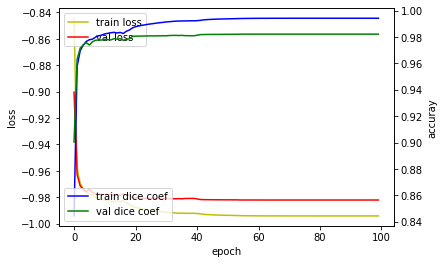

In [18]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(results.history['loss'], 'y', label='train loss')
loss_ax.plot(results.history['val_loss'], 'r', label='val loss')

acc_ax.plot(results.history['dice_coef'], 'b', label='train dice coef')
acc_ax.plot(results.history['val_dice_coef'], 'g', label='val dice coef')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

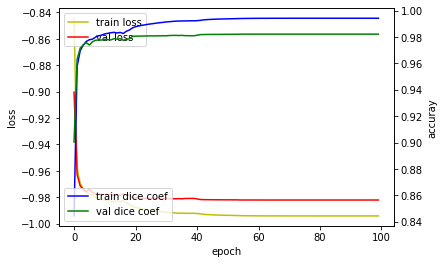

In [19]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(results.history['loss'], 'y', label='train loss')
loss_ax.plot(results.history['val_loss'], 'r', label='val loss')

acc_ax.plot(results.history['dice_coef'], 'b', label='train dice coef')
acc_ax.plot(results.history['val_dice_coef'], 'g', label='val dice coef')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

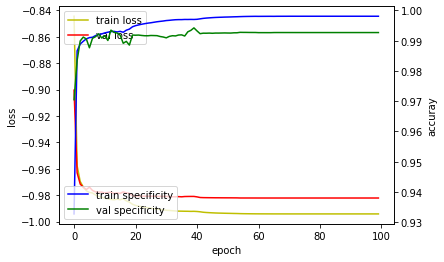

In [20]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(results.history['loss'], 'y', label='train loss')
loss_ax.plot(results.history['val_loss'], 'r', label='val loss')

acc_ax.plot(results.history['specificity'], 'b', label='train specificity')
acc_ax.plot(results.history['val_specificity'], 'g', label='val specificity')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

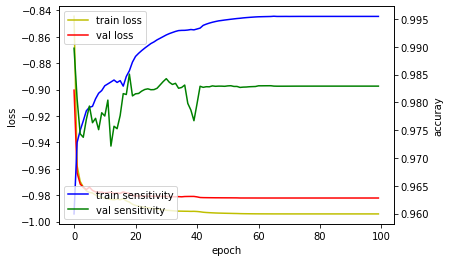

In [21]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(results.history['loss'], 'y', label='train loss')
loss_ax.plot(results.history['val_loss'], 'r', label='val loss')

acc_ax.plot(results.history['sensitivity'], 'b', label='train sensitivity')
acc_ax.plot(results.history['val_sensitivity'], 'g', label='val sensitivity')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

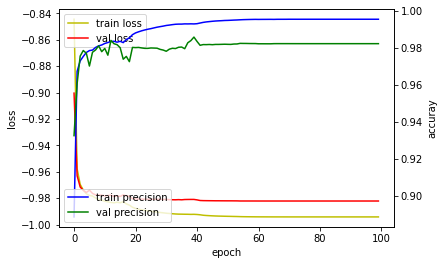

In [22]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(results.history['loss'], 'y', label='train loss')
loss_ax.plot(results.history['val_loss'], 'r', label='val loss')

acc_ax.plot(results.history['precision'], 'b', label='train precision')
acc_ax.plot(results.history['val_precision'], 'g', label='val precision')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [ ]:
print(results.history['precision'][-1])

NameError: ignored

In [ ]:
print(results.history['dice_coef'][-1])

0.9918906688690186


In [ ]:
print(results.history['specificity'][-1])

0.996821403503418


testing values


# testing values

In [28]:

# import os
test_list = os.listdir("test_set/")
print("The number of test data : ", len(test_list))
test_list[:5]



The number of test data :  335


['001_HC.png', '000_HC.png', '003_HC.png', '004_HC.png', '002_HC.png']

In [29]:
#used just for prediction, not as a checkpoint
model = tf.keras.models.load_model('best_model_224_VUNET_reducelr_2802.h5', custom_objects={'dice_coef_loss': dice_coef_loss, 'dice_coef':dice_coef,'specificity':specificity,'sensitivity':sensitivity,'precision':precision})

In [30]:


# X_test = np.empty((len(test_list), IMG_HEIGHT, IMG_WIDTH,3), dtype = 'float32')
# for i, item in enumerate(test_list):
#     image = cv2.imread("test_set/" + item)
#     # print(np.array(image).shape)/
#     image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)
#     X_test[i] = image
# X_test = X_test/ 255

# y_pred = model.predict(X_test)



In [31]:

def getbound(binary_mask):

  # draw = np.zeros((*img.shape, 3), dtype=np.uint8)

  # draw[img > 0.5] = (255,) * 3
  kernelSize = (3,3)

  # gray = cv2.cvtColor(draw, cv2.COLOR_BGR2GRAY)
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize)
  gradient = cv2.morphologyEx(binary_mask, cv2.MORPH_GRADIENT, kernel)
  # plt.imshow()
  # plt.show()
  # gradient = cv2.cvtColor(gradient, cv2.COLOR_GRAY2RGB)
  return gradient


def fitEllipse(binary_mask, method="Direct"):
    assert binary_mask.min() >= 0.0 and binary_mask.max() <= 1.0

    # print(binary_mask.shape)
   
    gradient  = getbound(binary_mask)

    # print(gradient.shape)

    points1 = np.argwhere(gradient > 0.5)  
    points2 = np.argwhere(binary_mask > 0.5)  

    points = points1
    # print(points1.shape)
    # print(points2.shape)

    if method == "AMS":
        (xx, yy), (MA, ma), angle = cv2.fitEllipseAMS(points)
    elif method == "Direct":
        (xx, yy), (MA, ma), angle = cv2.fitEllipseDirect(points)
    elif method == "Simple":
        (xx, yy), (MA, ma), angle = cv2.fitEllipse(points)

    return (xx, yy), (MA, ma), angle


In [32]:
# testing on first 50 images, these are from the training set, ground truths of X_test are not provided
X_50 = []
y_50 = []
for img, mask in zip(train_image, train_mask):
    img = cv2.imread(trainPath + img)
    mask = cv2.imread(trainPath + mask)
    X_50.append(img)
    
    y_50.append(mask)



X_test = np.empty((len(X_50[:]), IMG_HEIGHT, IMG_WIDTH,3), dtype = 'float32')



for i, image in enumerate(X_50[:]):
    # image = cv2.imread("test_set/" + item)
    # print(np.array(image).shape)
    image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)
    X_test[i] = image
    
X_test = X_test/ 255

y_pred = model.predict(X_test)


32/32 [==============================] - 21s 266ms/step


In [33]:


def getbound(binary_mask):

  # draw = np.zeros((*img.shape, 3), dtype=np.uint8)

  # draw[img > 0.5] = (255,) * 3
  kernelSize = (3,3)

  # gray = cv2.cvtColor(draw, cv2.COLOR_BGR2GRAY)
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize)
  gradient = cv2.morphologyEx(binary_mask, cv2.MORPH_GRADIENT, kernel)
  # plt.imshow()
  # plt.show()
  # gradient = cv2.cvtColor(gradient, cv2.COLOR_GRAY2RGB)
  return gradient

def get_largest_component(gray):
    # convert the image to grayscale
    # gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Convert to CV_8UC1 with scaling     
    scaled_img = cv2.convertScaleAbs(img, alpha=(255.0/np.max(img)))
    # apply thresholding to binarize the image
    _, thresh = cv2.threshold(scaled_img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    # find contours in the binary image
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # get the largest contour based on area
    largest_contour = max(contours, key=cv2.contourArea)

    # create a mask for the largest contour
    mask = np.zeros(img.shape[:2], np.uint8)
    cv2.drawContours(mask, [largest_contour], 0, 255, -1)

    # apply the mask to the original image to get only the largest component
    largest_component = cv2.bitwise_and(img, img, mask=mask)

    return largest_component


def commonRows(A, B):

    #reformat B
    B = np.squeeze( B, axis=1  )
    B = np.fliplr(B)

    aset = set([tuple(x) for x in A])
    bset = set([tuple(x. tolist() ) for x in B])
    
    return np.array([x for x in aset & bset])

def fitEllipse(binary_mask, method):
    assert binary_mask.min() >= 0.0 and binary_mask.max() <= 1.0

  
    #get largest contour
    img_gray_8bit = cv2.convertScaleAbs(binary_mask, alpha=(255.0/np.max(binary_mask)))
    contours, hierarchy = cv2.findContours(img_gray_8bit, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)
    # binary_mask = cv2.convertScaleAbs(largest_contour, alpha=(np.max(largest_contour)/255.0))
    
    # largest_component  = get_largest_component(binary_mask)
    gradient  = getbound(binary_mask)

    # print(gradient.shape)

    points1 = np.argwhere(gradient > 0.5)  


    points1 = commonRows(points1,largest_contour)
    
    points = points1


    if method == "AMS":
      #taubins method
        (xx, yy), (MA, ma), angle = cv2.fitEllipseAMS(points)
    elif method == "Direct":
      #Fitzgibbon1999
        (xx, yy), (MA, ma), angle = cv2.fitEllipseDirect(points)
    elif method == "Simple":
      #Fitzgibbon95]
        (xx, yy), (MA, ma), angle = cv2.fitEllipse(points)

    return (xx, yy), (MA, ma), angle


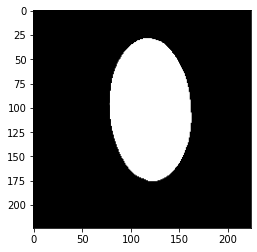

In [34]:
fig, ax = plt.subplots(1,1)
pr = y_pred[6].reshape((IMG_HEIGHT,IMG_WIDTH))
# p = cv2.cvtColor(y_pred[0][:,:], cv2.COLOR_BGR2GRAY)
ax.imshow( pr, cmap='gray')
# ax[1].imshow(te )
# y_pred = y_pred[y_pred > 0.5]
# print(y_pred[6])

In [35]:
def dice_coef(y_true, y_pred):
    # convert to 2D before comparing results
    # y_true = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    # print(np.array(y_true).shape)
    # print(np.array(y_pred).shape)
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)


    # print((2. * intersection ) / (K.sum(y_true_f) + K.sum(y_pred_f) ))
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def jac_distance(y_true, y_pred ):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    # intersection = K.sum(y_true_f * y_pred_f)

    intersection = K.sum(K.abs(y_true_f * y_pred_f), axis=-1)
    sum_ = K.sum(K.abs(y_true_f) + K.abs(y_pred_f), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)

    # print(jac)
    return jac

In [36]:
i=0

dice_val = []
jac_val = []
# ellipse_val = []
precision_val = []
specificity_val = []
sensitivity_val  = []

ellipse_val_direct = []
ellipse_val_direct_img = []
ellipse_val_direct_dice = []

ellipse_val_AMS = []
ellipse_val_AMS_img = []
ellipse_val_AMS_dice = []

ellipse_val_Simple = []
ellipse_val_Simple_img = []
ellipse_val_Simple_dice = []

for test, pred in zip(X_test[:],y_pred[:]):
    
    y_true = cv2.cvtColor(y_50[i], cv2.COLOR_BGR2GRAY)
    y_true = cv2.resize(y_true, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)
    y_true = np.array(y_true).astype(float) / 255.0
    y_p = np.array(pred).astype(float)  


    dice = dice_coef( y_true, y_p)
    jac = jac_distance(y_true, y_p)
    pr = precision( y_true, y_p)
    sp = specificity( y_true, y_p)
    se = sensitivity( y_true, y_p)

    dice_val.append(dice)
    jac_val.append(jac)
    precision_val.append(pr)
    specificity_val.append(sp)
    sensitivity_val.append(se)
    i=i+1

    # fig, ax = plt.subplots(1,4,figsize = (16,16))
    # test = test.reshape((IMG_HEIGHT,IMG_WIDTH,3))

    pred = pred.reshape((IMG_HEIGHT,IMG_WIDTH))

    img1 = pred.copy()
    (xx1, yy1), (MA1, ma1), angle1 = fitEllipse(img1,method="Direct")
    # print((xx, yy), (MA, ma), angle)
    ellipse_val_direct.append([(xx1, yy1), (MA1, ma1), angle1])
    img1 = np.zeros((IMG_HEIGHT, IMG_WIDTH, 3), np.uint8)
    
    cv2.ellipse(
        img1,
        (int(yy1), int(xx1)),
        (int(ma1 / 2), int(MA1 / 2)),
        -angle1,
        0,
        360,
        color=(255, 255, 255),
        thickness=-1,
    )
    
    ellipse_val_direct_img.append(img1)
    img1 =  cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    ed = dice_coef( y_true, np.array(img1).astype(float)/255.0)
    ellipse_val_direct_dice.append(ed)



    #AMS
    img2 = pred.copy()
    (xx2, yy2), (MA2, ma2), angle2 = fitEllipse(img2,method="AMS")
    # print((xx, yy), (MA, ma), angle)
    ellipse_val_AMS.append([(xx2, yy2), (MA2, ma2), angle2])
    img2 = np.zeros((IMG_HEIGHT, IMG_WIDTH, 3), np.uint8)
    cv2.ellipse(
        img2,
        (int(yy2), int(xx2)),
        (int(ma2 / 2), int(MA2 / 2)),
        -angle2,
        0,
        360,
        color=(255, 255, 255),
        thickness=-1,
    )
    
    ellipse_val_AMS_img.append(img2)
    img2 =  cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    ed = dice_coef( y_true, np.array(img2).astype(float)/255.0)
    ellipse_val_AMS_dice.append(ed)

    #simple
    img3 = pred.copy()
    (xx3, yy3), (MA3, ma3), angle3 = fitEllipse(img3,method="Simple")
    # print((xx, yy), (MA, ma), angle)
    ellipse_val_Simple.append([(xx3, yy3), (MA3, ma3), angle3])
    img3 = np.zeros((IMG_HEIGHT, IMG_WIDTH, 3), np.uint8)
    cv2.ellipse(
        img3,
        (int(yy3), int(xx3)),
        (int(ma3 / 2), int(MA3 / 2)),
        -angle3,
        0,
        360,
        color=(255, 255, 255),
        thickness=-1,
    )
    
    ellipse_val_Simple_img.append(img3)
    img3 =  cv2.cvtColor(img3, cv2.COLOR_BGR2GRAY)
    ed = dice_coef( y_true, np.array(img3).astype(float)/255.0)
    ellipse_val_Simple_dice.append(ed)


    # draw = np.zeros((*img.shape, 3), dtype=np.uint8)

    # draw[img < 0.5] = (255,) * 3

    # cv2.ellipse(
    #     draw,
    #     (int(yy), int(xx)),
    #     (int(ma / 2), int(MA / 2)),
    #     -angle,
    #     0,
    #     360,
    #     color=(255, 0, 0),
    #     thickness=2,
    # )
    
    # pred = pred>0.5
    # pred = np.ma.masked_where(pred == 0, pred)

    # ax[0].imshow(test, cmap = 'gray')

    # ax[1].imshow(pred, cmap = 'gray')

    # ax[2].imshow(test, cmap = 'gray', interpolation = 'none')
    # ax[2].imshow(pred, cmap = 'jet', interpolation = 'none', alpha = 0.7)

    # ax[3].text(3, 7, 'dice ' + str(round(float(dice),4)) + '\njacc ' + str(round(float(jac),4)), fontsize = 15, color = 'g')

    # ax[3].imshow(draw,cmap='jet')

In [37]:

import pandas as pd

In [38]:
#take input as index
def showImage(i,method):
  test = X_test[i]
  pred = y_pred[i]
  
  draw = np.zeros((*img.shape,), dtype=np.uint8)
  draw = draw + 255  
    # # draw[img > 0.5] = (255,) * 3

  # y_true = cv2.imread("training_set/" + y_50[i])
  y_true = cv2.cvtColor(y_50[i], cv2.COLOR_BGR2GRAY)
  y_true = cv2.resize(y_true, (IMG_HEIGHT, IMG_WIDTH), interpolation=cv2.INTER_AREA)
  y_true = np.array(y_true).astype(float) / 255.0
  y_p = np.array(pred).astype(float)
  dice = dice_coef( y_true, y_p)
  jac = jac_distance(y_true, y_p)

  # count = np.count_nonzero(y_true > 0.01)
  # print(count)
  # count = np.count_nonzero(y_p > 0.1)
  # print(count)
  img3 = pred.copy()

  # largest_component = get_largest_component(img3)

  # print(largest_component.shape)

  (xx3, yy3), (MA3, ma3), angle3 = fitEllipse(img3, method)

  img3 = np.zeros((IMG_HEIGHT, IMG_WIDTH, 3), np.uint8)
  cv2.ellipse(draw, (int(yy3), int(xx3)), (int(ma3 / 2), int(MA3 / 2)), -angle3, 0, 360,color=(0, 0, 0), thickness=-1)
  cv2.ellipse(img3, (int(yy3), int(xx3)), (int(ma3 / 2), int(MA3 / 2)), -angle3, 0, 360,color=(255, 255, 255), thickness=-1)
  img3 =  cv2.cvtColor(img3, cv2.COLOR_BGR2GRAY)
  ed = dice_coef( y_true, np.array(img3).astype(float)/255.0)
  ej = jac_distance( y_true, np.array(img3).astype(float)/255.0)

  fig, ax = plt.subplots(1, 4, figsize=(16, 16))

  test = cv2.cvtColor(test, cv2.COLOR_BGR2GRAY)
  # pred = cv2.cvtColor(pred, cv2.COLOR_BGR2GRAY)

  test = test.reshape((IMG_HEIGHT, IMG_WIDTH))
  pred = pred.reshape((IMG_HEIGHT, IMG_WIDTH))
# 
  ax[0].imshow(test, cmap='gray')
  ax[0].text(3,7, ' '+ str(i),fontsize=14,color='r')
  ax[1].imshow(pred, cmap='gray', interpolation='none')
  ax[1].imshow(y_true, cmap='jet', interpolation='none', alpha=0.7)
  ax[1].text(3, 7, 'dice ' + str(round(float(dice), 4)) + '\njacc ' + str(round(float(jac), 4)), fontsize=15, color='g')

  ax[2].imshow(test, cmap='gray', interpolation='none')
  ax[2].imshow(pred, cmap='jet', interpolation='none', alpha=0.7)

  ax[3].imshow(draw, cmap='gray')
  ax[3].imshow(y_true, cmap='jet', interpolation='none', alpha=0.7)
  ax[3].text(3, 7, 'dice ' + str(round(float(ed), 4)) + '\njacc ' + str(round(float(ej), 4)), fontsize=15, color='g')


#Analysis

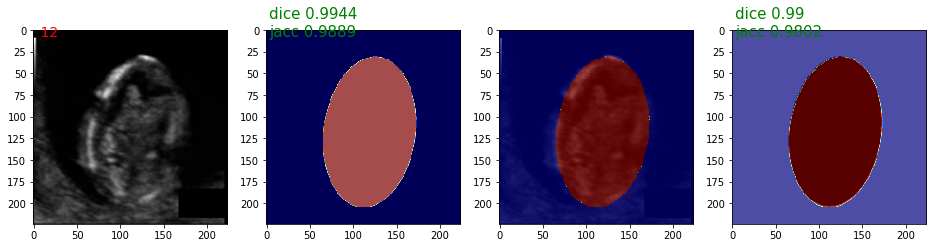

In [39]:
showImage(12,"AMS")

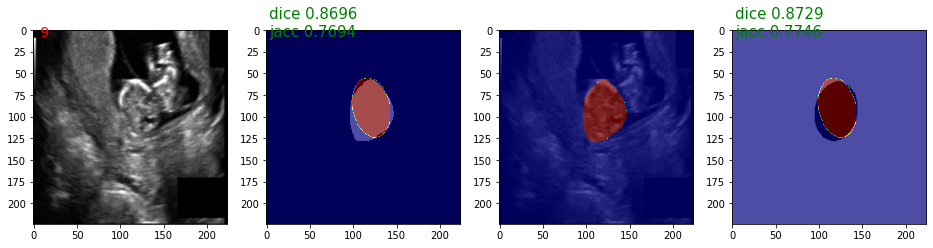

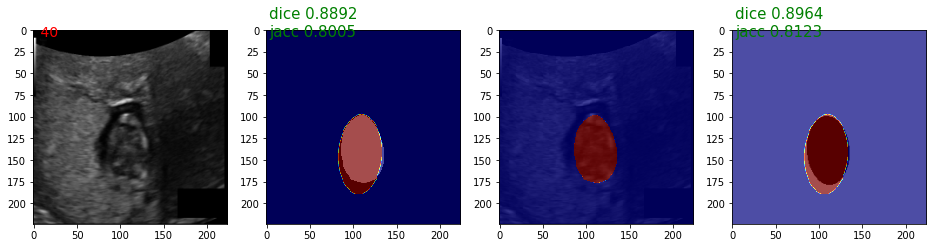

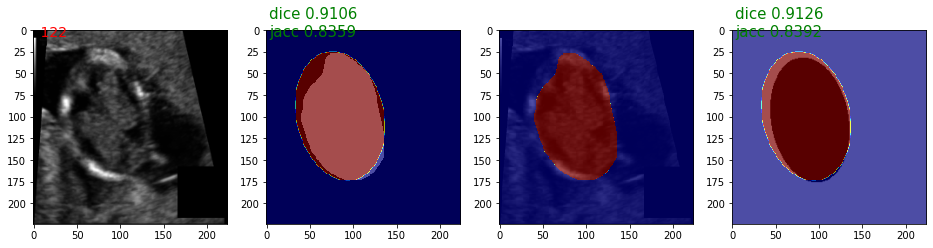

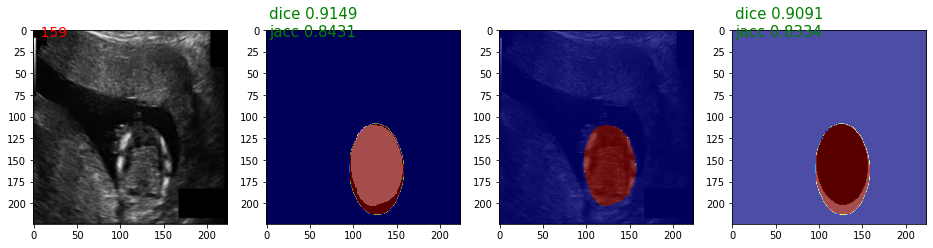

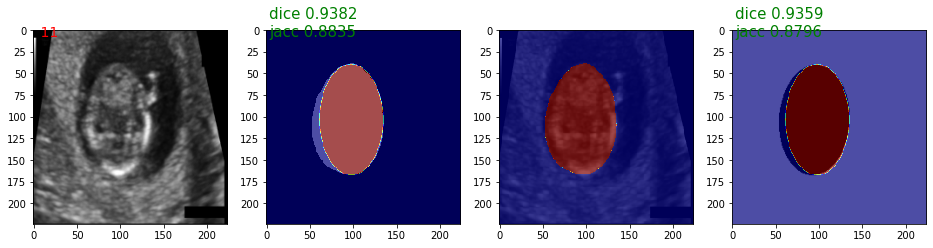

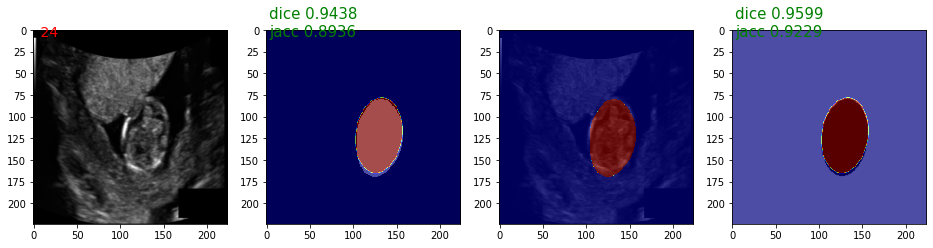

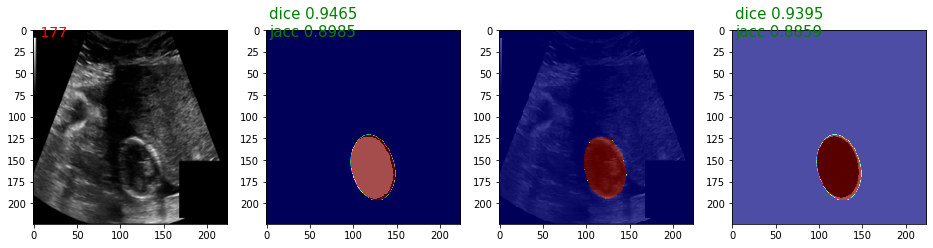

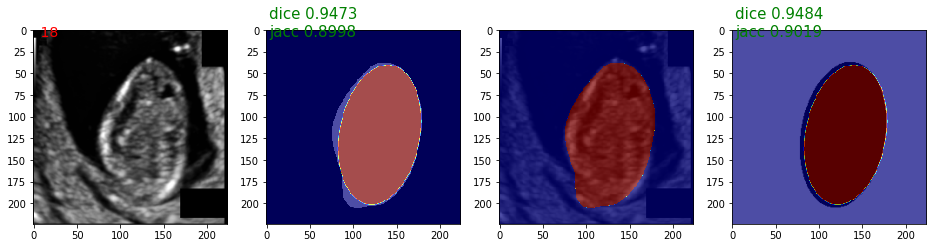

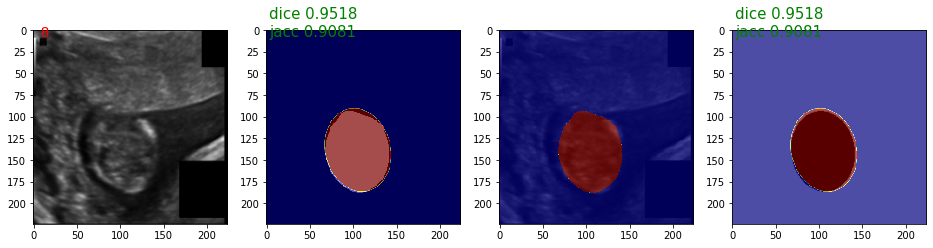

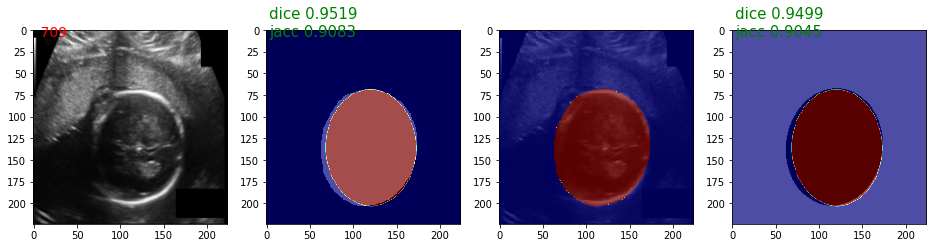

In [40]:

lowest_indices = np.argsort(dice_val)[0:10]
for i in lowest_indices:
  showImage(i,"AMS")

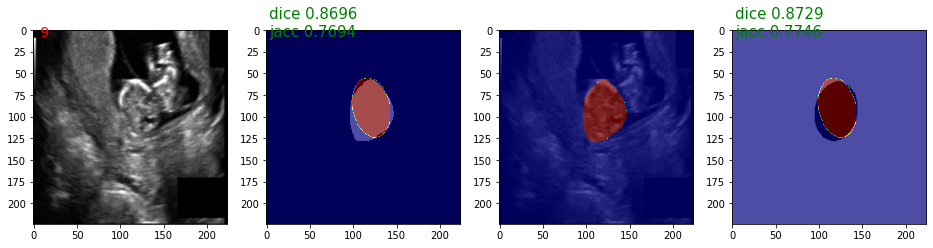

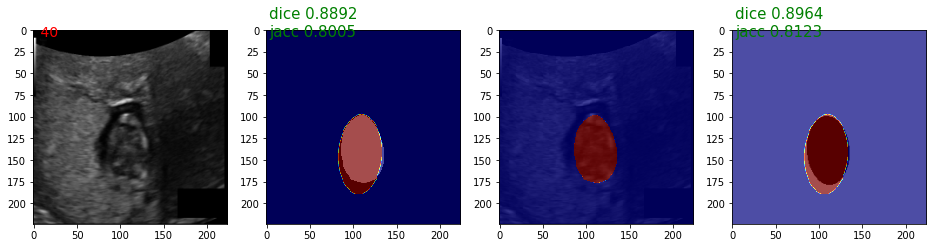

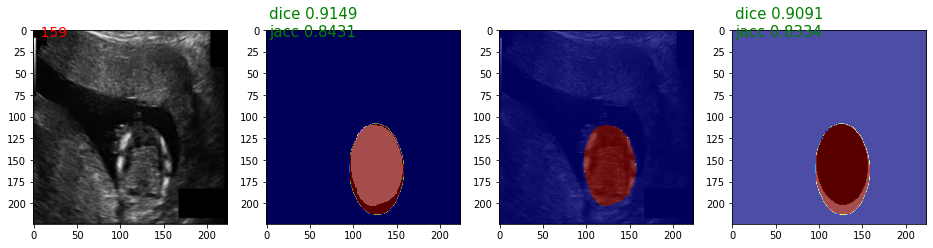

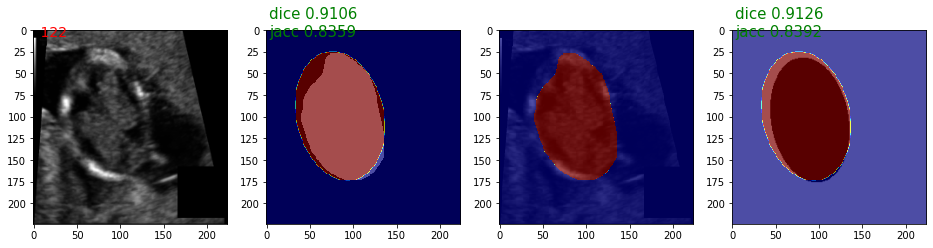

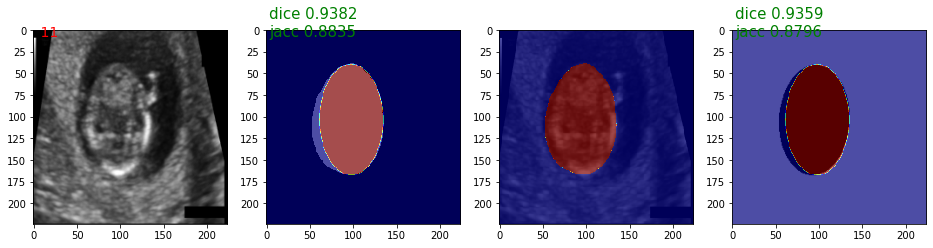

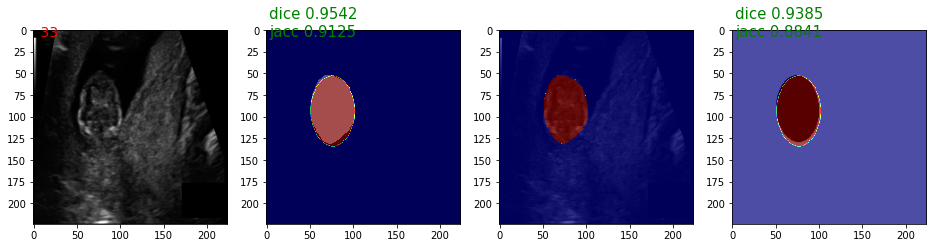

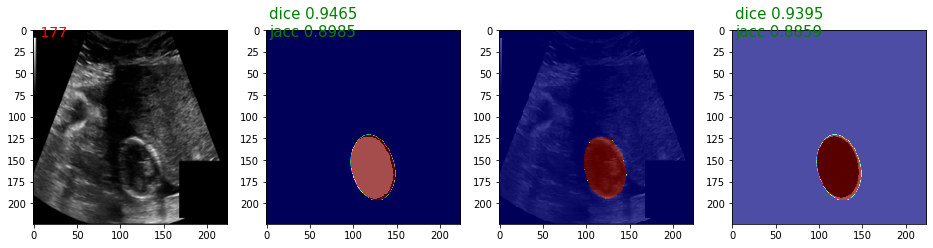

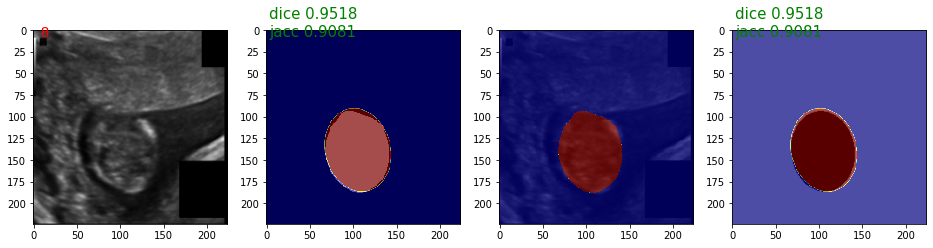

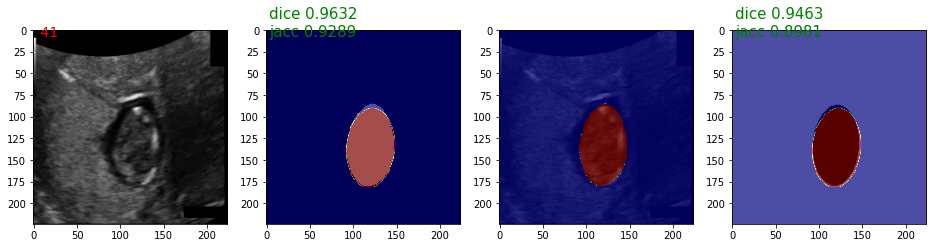

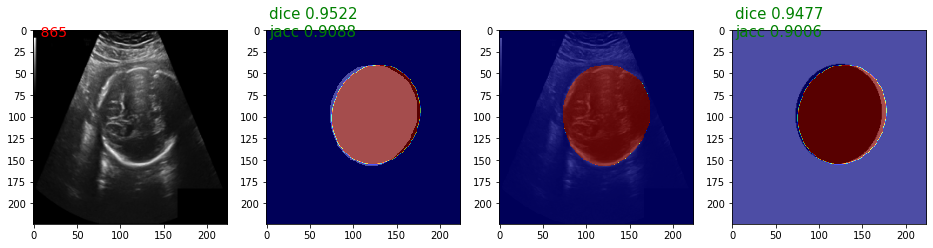

In [41]:
lowest_indices = np.argsort(ellipse_val_direct_dice)[0:10]
for i in lowest_indices:
  showImage(i,"AMS")

# Test Results

In [42]:
#evalutte test set
# # import os
# test_list = os.listdir("test_set/")
# # print("The number of test data : ", len(test_list))
# # test_list[:5]


# X_test = np.empty((len(test_list), IMG_HEIGHT, IMG_WIDTH), dtype = 'float32')
# for i, item in enumerate(test_list):
#     image = cv2.imread("test_set/" + item, 0)
#     image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)
#     X_test[i] = image

# X_test = X_test[:,:,:,np.newaxis] / 255
# #used just for prediction, not as a checkpoint
# model = tf.keras.models.load_model('best_model_224_res.h5', custom_objects={'dice_coef_loss': dice_coef_loss, 'dice_coef':dice_coef,'specificity':specificity,'sensitivity':sensitivity,'precision':precision})
# model.compile(optimizer=Adam(lr = 1e-4), loss=dice_coef_loss, metrics=['accuracy',dice_coef,specificity,sensitivity,precision,])

# # evaluate_gen =
# # y_pred = model.predict(X_test)

# y_pred = model.predict(X_test)



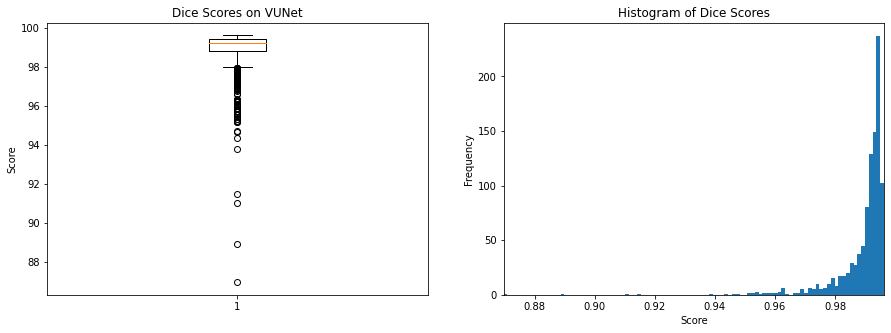

In [43]:

# Generate some random dice scores
dice_scores = np.array(dice_val)

#remove 1 outlier
# dice_scores = dice_scores[dice_scores != np.min(dice_scores)]



# Create a boxplot of the dice scores
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].boxplot(dice_scores*100)
axs[0].set_title('Dice Scores on VUNet')
axs[0].set_ylabel('Score')

# Create a Bland-Altman plot of the dice scores
# mean = np.mean(dice_scores)
# diff = dice_scores - mean
# mean_diff = np.mean(diff)
# std_diff = np.std(diff)
# limit_of_agreement = 1.96 * std_diff
# lower_loa = mean_diff - limit_of_agreement
# upper_loa = mean_diff + limit_of_agreement
# axs[1].scatter(np.full(len(diff), mean), diff)
# axs[1].axhline(mean_diff, color='black', linestyle='--')
# axs[1].axhline(lower_loa, color='red', linestyle='--')
# axs[1].axhline(upper_loa, color='red', linestyle='--')
# axs[1].set_title('Bland-Altman Plot')
# axs[1].set_xlabel('Mean of Dice Scores')
# axs[1].set_ylabel('Difference from Mean')

# Create a histogram of the dice scores
axs[1].hist(dice_scores, bins=100)
axs[1].set_xlim([min(dice_scores), max(dice_scores)])
axs[1].set_title('Histogram of Dice Scores')
axs[1].set_xlabel('Score')
axs[1].set_ylabel('Frequency')



plt.show()
